# Gen AI Podcast

Cria um podcast com auxilio de agentes baseados em inteligência artificial (GenAI).

In [3]:
import pandas as pd
import numpy as np
from typing import Dict, Any
from langchain_community.chat_models import ChatOllama
from alpha_vantage.timeseries import TimeSeries
import requests
from dotenv import load_dotenv 
import json
from huggingface_hub import InferenceClient
from PIL import Image
import os
import time

## Parametros e Chaves

In [4]:
HUGGINGFACE_TOKEN = os.environ["HF_TEXT_TO_IMAGE"]
MODEL_NAME = "black-forest-labs/FLUX.1-dev"  # Modelo moderno e ativo

## Modelos

### Warpper para os modelos LLMs

In [94]:
class GenImage:
    def __init__(self, model, token):
        self.client = InferenceClient(model=model, token=token)

    def setClient(self, client: InferenceClient):
        self.client = client
    def make_image(self, prompt: str, output_path: str = "saida.png"):
        """
        Gera uma imagem a partir de um prompt de texto e salva no disco.
        """
        print(f"🧠 Gerando imagem para o prompt:\n  \"{prompt}\"\n")
    
        # Gera a imagem
        image = self.client.text_to_image(
            prompt=prompt,
            negative_prompt="imagem borrada, baixa qualidade, arte ruim",
            guidance_scale=7.5,
            num_inference_steps=30,
            width=512,
            height=512,
        )
    
        # Salva e exibe
        image.save(output_path)
        print(f"✅ Imagem salva como: {output_path}\n")
        try:
            image.show()
        except Exception:
            pass
        return image

In [65]:
import requests

class GenAudio:
    def __init__(self, token):
        self.API_URL = "https://router.huggingface.co/fal-ai/fal-ai/kokoro/brazilian-portuguese"
        self.headers = {
            "Authorization": f"Bearer {token}",
        }
    def query(self, payload):
        response = requests.post(self.API_URL, headers=self.headers, json=payload)
        return response.json()

### Agentes

In [7]:
class LlamaAgent:
    def __init__(self, model="gemma3:1b", url="http://localhost:11434/api/generate"):
        self.model = model
        self.url = url

    def ask(self, prompt: str) -> str:
        resp = requests.post(self.url, json={"model": self.model, "prompt": prompt, "stream": False})
        return resp.json()["response"]


In [68]:
import re

def clean_text(text, regexs):
    for s in regexs:
        text = re.sub(fr'{s}', '', text) 
    return text

class CopyWriterAgent:
    def __init__(self, llama_agent: LlamaAgent):
        self.llama = llama_agent
        
    def run(self, features: dict):
        prompt = f"""
        Você é um especialista na criação de roteiros de podcast.
        Você possui as seguintes habilidades:
        - Conhecimento profundo na criação de podcast.
        - Roteirização e estruturação de conteúdo.
        - Comunicação eficaz.
        - Preparação e pesquisa.
        - Adaptabilidade, flexibilidade e criatividade.
        - Consistência e organização.

        Contexto: 
        {features['context']}
        
        Tarefa: 
        {features['task']}

        Regras: 
        {features['rules']}
        """

        #- A saída deve começar e terminar diretamente com o conteudo da tarefa, mas fique atento as regras anteriores.
        #- Não adicione introduções (Ex: 'Aqui estão ...'), concluções (ex:'Espero que ajude...'), 
        #ou qualquer tipo de comentário de adicional ou cortesia.

        response = self.llama.ask(prompt)
        return {"text": response}

In [31]:
class ArtistAgent:
    def __init__(self, gen_image: GenImage):
        self.agent = gen_image

    def run(self, features: dict):
        prompt = f"""
        Você é um artista especialista na criação de imagens para capa de podcast.
        
        Tarefa: 
        {features["task"]}

        Configurações da imagem: 
        {features['config']}

        Parâmetros: 
        {features['params']}
        """
        response = self.agent.make_image(prompt, f"img-{time.time()}.png")
        return {"image": response}

In [86]:
class AudioAgent:
    def __init__(self, gen_audio: GenAudio):
        self.agent = gen_audio
    def run(self, features: str):
        audio = self.agent.query({"prompt": features, "voice": "pm_alex"})
        return {"audio": audio}

## Prompts

Os prompts são dicionários com a seguinte estrutura:
- context: define o contexto/situação em que o agente se encontra (lembrando que os agentes já possuem Papeis/Especialização definidas).
- task: è a tarefa/obejtivo que o agente deve realizar.
- rules: são as regras, restrições ou formatações que o modelo deve levar em conta durante a realização da tarefa.
- config: são as configurações da imagem.
- params: são os parametros que o modelo da agente deve levar em conta. 

In [89]:
podcaster_features = {
    "context": """vamos criar um podcast de tecnologia, focado em front end. 
    O podcast vai falar sobre dicas e novidades sobre o mundo do front end e o que está acontecendo no mercado""",
    "task": """criar 5 sugestões de nomes criativos para um podcast de front end feito por nerds, e que tenha algum trocadilho pop/nerd no nome""",
    "rules":"""
    - A saída deve conter apenas: nome, subtítulo e por que funciona.
    - O nome deve ser enxuto.
    - O nome tenha algum trocadilho nerd com nomes de franquias conhecidas como harry potter, star wars, senhor dos anéis,
    transformer, marvel, DC, missão impossível, jurassic park, etc.
    - O nome deve conter alguma palavra forte que remeta a front end.
    - O nome não deve conter palavras em inglês.
    - Não utilizar nenhuma das palavras desta lista: [javascript, programador, dev, jovem, nerd].
    - Não utilizar a palavra frontend no nome nem qualquer variação dela.
    """
}

roteirista_features = {
    "context":"""
    Vamos criar um  roteiro de um podcast de tecnologia, focado em frontend cujo o nome é "Nexus Front - Conectando o futuro do web"
    e tem foco em frontend, com o público alvo de iniciantes em frontend
    """
    ,
    "task":"Escrever um roteiro de um podcast de tecnologia, focado em frontend , com o público alvo de iniciantes em frontend.",
    "rules":"""
    - O formato da saída deve conter apenas:
        [INTRODUÇÃO]
        [CURIOSIDADE 1]
        [CURIOSIDADE 2]
        [FINALIZAÇÃO]
    - No bloco [INTRODUÇÃO] substitua por uma introdução iguais as introduções dos vídeos do canal 'ei nerd', como se fossem escritos pelo Peter Jordan.
    - No bloco [CURIOSIDADE 2] sobre uma ferramenta para front ends.
    - No bloco [FINALIZAÇÃO] substitua por uma despedida cool com o final 'Eu sou Bruno e esse foi o Nexus Front dessa semana'.
    - Use termos de fácil explicação.
    - O podcast vai ser apresentado somente por uma pessoa, chamada Bruno.
    - O podcast deve ser curto.
    - Não use muitos termos técnicos.
    - Não ultrapasse 5 minutos de duração
    """
}

artista_features = {
    "task": "create knight character as podcaster medieval with microphone",
    "config": "retro style, isometric, cube, game style, low resolution, down angle , game boy colors, 8 bits, retro sprites",
    "params": "--ar 1:1"
}

## Testes

Atualmente cada agente realiza sua tarefa isoladamente. O objetivo é no futuro integrar e coordenar as tarefas de cada agente.

Os Agentes são:

- podcaster: Responsável por criar o nome do podcast.
- roteirista: responsável por escrever o roteiro do podcast.
- artista: responsável por criar a capa do podcast.
- locutor: responsável por narrar o podcast.

In [95]:
llama = LlamaAgent("gemma3:1b")
genImage = GenImage(MODEL_NAME, HUGGINGFACE_TOKEN)
genAudio = GenAudio(HUGGINGFACE_TOKEN)
podcaster = CopyWriterAgent(llama) # podcaster faz o papel de escolher o titulo e escrever o roteiro
artista = ArtistAgent(genImage)
locutor = AudioAgent(genAudio)

### Criar o título do podcast 

In [41]:
resp = podcaster.run(features=podcaster_features)

In [42]:
print(resp['text'])

## 5 Sugestões de Nomes Criativos para o Podcast de Front End:

Aqui estão 5 sugestões de nomes que combinam elementos de tecnologia, nerd e trocadilho, visando um podcast de front end com foco em novidades e dicas:

1.  **Nome:** "Código Sombrio"
    *   **Subtítulo:** "Desvendando o Código, um Byte de Sabedoria."
    *   **Por que funciona:** A palavra "Código" é central para o tema, e "Sombrio" evoca a ideia de profundidade e mistério, inspirando-se em Harry Potter.

2.  **Nome:** "Raster & Pixel"
    *   **Subtítulo:** "A Arte da Interface, com a Precisão do Desenho."
    *   **Por que funciona:** "Raster" e "Pixel" são termos cruciais para o front end, combinados em uma frase que sugere o foco em design e construção visual.

3.  **Nome:** "A Plataforma Fantasma"
    *   **Subtítulo:** "Onde a Tecnologia se Revela em Silêncio."
    *   **Por que funciona:** "Fantasma" cria um senso de mistério e descoberta, aludindo à complexidade do código e à experiência de usar ferramentas de fr

#### 5 Sugestões de Nomes Criativos para o Podcast de Front End:
1. **Nome:** "O Código Mágico"
   *   **Subtítulo:** "Desvendando o front end, um passo de cada vez."
   *   **Trajojado:** A ideia é despertar a curiosidade e a fantasia do público, combinando a complexidade da tecnologia com a magia do desenvolvimento.
2. **Nome:** "Nexus Front"
   *   **Subtítulo:** "Conectando o futuro do web."
   *   **Trajojado:** "Nexus" (liderado) e "Front" (o front) ao mesmo tempo, criando uma sensação de conexão e importância no mundo digital.
3. **Nome:** "Pixelado e Poderoso"
   *   **Subtítulo:** "Analisando as tendências, moldando o futuro do design web."
   *   **Trajojado:** Jogando com a imagem visual do front end, transmitindo a ideia de conhecimento e capacidade.
4. **Nome:** "Estrutura em Movimento"
   *   **Subtítulo:** "Entendendo o DNA do web."
   *   **Trajojado:** Uma alusão à estrutura de um site, mas com a ideia de que está em constante evolução, como um sistema que se adapta.
6. **Nome:** "Decodificando Web"
   *   **Subtítulo:** "Um guia para o digital, revelando os segredos do front end."
   *   **Trajojado:** Enfatiza o processo de compreensão e o desenvolvimento do front end, transmitindo a ideia de um "desvento" da complexidade digital.

### Roteirista do podcast

Respósavel por escrever o epsódio da semana.

In [44]:
resp = podcaster.run(features=roteirista_features)

In [91]:
# limpamos a saída para visualizar o resultado.
cresp = clean_text(resp['text'],["\[.*?\]", "\(.*?\)","(.)\1{2,}","\*"]).strip()
print(cresp)

## Nexus Front - Conectando o Futuro do Web





Olá, pessoal! Sejam bem-vindos ao Nexus Front, o podcast que te ajuda a entender o básico do frontend. Eu sou Bruno, e hoje, estamos explorando um dos pilares da web: a criação de interfaces de usuário que funcionam bem.  Acho que a gente tem todos esses conceitos de 'React', 'Vue', 'Angular' por aí, mas entender o porquê de tudo isso funciona é fundamental, né?  Vamos desmistificar um pouco essa área e descobrir como você pode começar a construir seus próprios sites e aplicativos.  Se você é um iniciante, ou está se sentindo um pouco perdido, esse é o seu podcast!  Vamos mergulhar e entender como o código que vemos em sites, aplicativos e jogos é realmente construído.  Se você quer se tornar um desenvolvedor frontend, essa é a sua chance.  Deixe seu like, se inscreva no canal e ative o sininho para não perder nenhum episódio!  Eu sou Bruno e esse foi o Nexus Front dessa semana.





E falando de ferramentas, e um tópico que tem dado mui

### Locutor

recebe a saída já tratada e narra o epsódio da semana.

In [83]:
resp_audio = locutor.run(cresp)

In [84]:
print(resp_audio['audio'])

{'error': 'Invalid JSON'}


### Artista

cria a capa do podcast

In [ ]:
resp_image = artista.run(features=artista_features)

🧠 Gerando imagem para o prompt:
  "
    Você é um artista especialista na criação de imagens para capa de podcast.
    
    Tarefa: 
    create knight character as podcaster medieval with microphone

    Configurações da imagem: 
    retro style, isometric, cube, game style, low resolution, down angle , game boy colors, 8 bits, retro sprites

    Parâmetros: 
    --ar 1:1
    "

    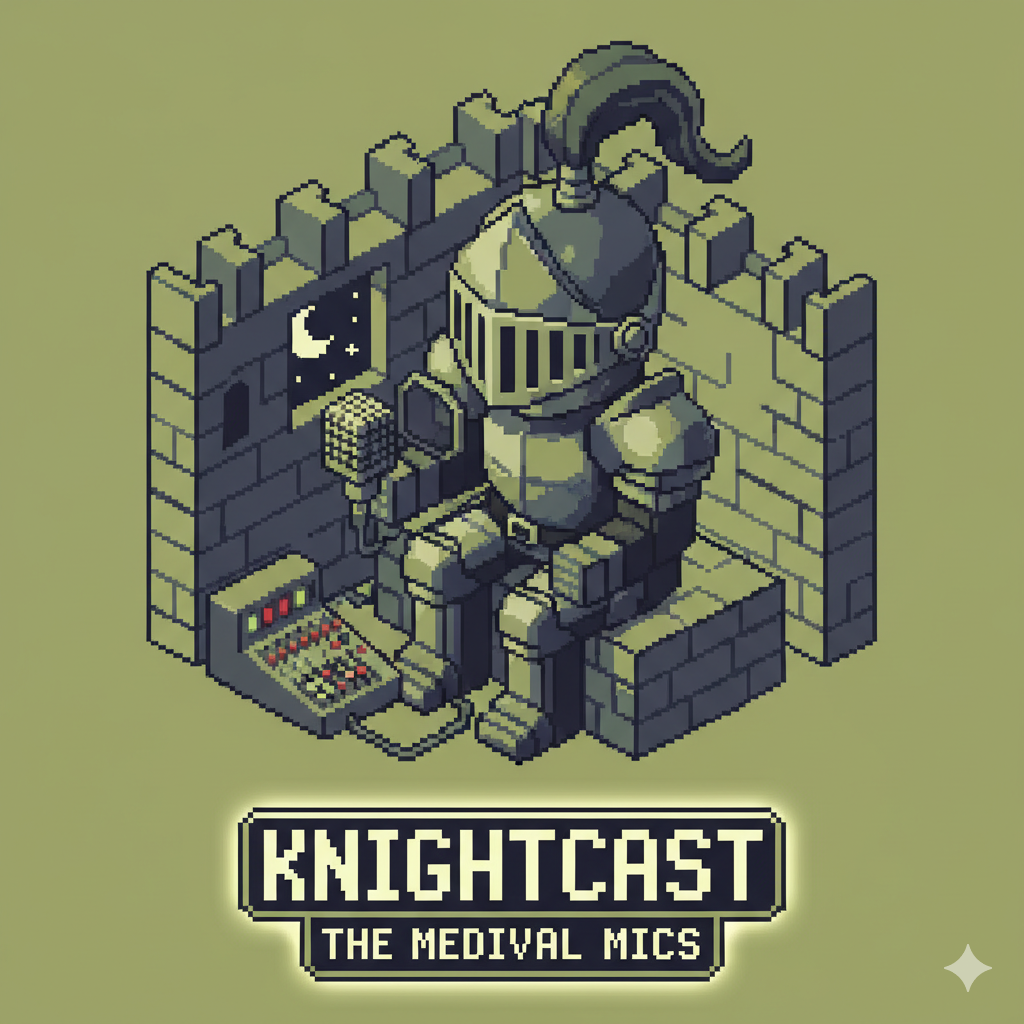